In [4]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
nltk.download('vader_lexicon')
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm import tqdm
from datetime import datetime

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mehdimouden/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_6714/3052469637.py:9: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tweets.csv', sep=';')


,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


1. Pre-processing of the tweets

In [ ]:
# Load your CSV data into a DataFrame
df = pd.read_csv('tweets.csv', sep=';')
df.head()

In [7]:
# Define a function to preprocess the text by removing hashtags, non-English characters, and URLs
def preprocess_text(text):
    if isinstance(text, str): 
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove non-English alphabet characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
    else:
        text = ''
    return text

In [8]:
# Apply the preprocessing function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)
df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,appena uscito un nuovo video LES CRYPTOMONNAIE...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano Digitize Currencies EOS ROI ATampT Bit...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasnt caught in the st...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices BTC USD ETH USD LTC USD ...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv Nosar Baz BITCOIN Is An Asset amp NOT A C...


2. Sentiment Analysis with VADER

In [9]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
# Create a function to apply VADER sentiment analysis and add sentiment scores to the DataFrame
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment
# Create a function to calculate weights for each tweet
def calculate_weights(tweet):
    weight = tweet['likes'] + tweet['retweets'] + tweet['replies'] +1
    return weight if weight > 0 else 1  # Ensure a non-zero minimum weight
# Create a function to calculate weighted average sentiment
def weighted_average(group):
    weighted_sentiments = group['compound_sentiment'] * group['weight']
    return weighted_sentiments.sum() / group['weight'].sum()


In [11]:
# Apply the sentiment analysis function to the preprocessed 'text' column
df['sentiment'] = df['text'].apply(get_sentiment)
df['compound_sentiment'] = df['sentiment'].apply(lambda x: x['compound'])
df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text,sentiment
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,appena uscito un nuovo video LES CRYPTOMONNAIE...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano Digitize Currencies EOS ROI ATampT Bit...,"{'neg': 0.123, 'neu': 0.877, 'pos': 0.0, 'comp..."
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasnt caught in the st...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices BTC USD ETH USD LTC USD ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv Nosar Baz BITCOIN Is An Asset amp NOT A C...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp..."


In [199]:
# Convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate weights for each tweet
df['weight'] = df.apply(calculate_weights, axis=1)
# Group the tweets published on the same day using their weights
df_vader = df.groupby(df['timestamp'].dt.date).apply(weighted_average).reset_index()
df_vader.columns = ['timestamp', 'weighted_avg_sentiment']

# Print the resulting df_vader DataFrame
print(df_vader)

KeyboardInterrupt: 

In [244]:
# Convert the 'timestamp' column in df_vader to the desired date format
df_vader['timestamp'] = pd.to_datetime(df_vader['timestamp'], format='%Y-%m-%d')

# Calculate the rolling minimum and maximum over a 1-year window
rolling_min = df_vader['weighted_avg_sentiment'].rolling(365, min_periods=1).min()
rolling_max = df_vader['weighted_avg_sentiment'].rolling(365, min_periods=1).max()

# Apply min-max scaling to the 'weighted_avg_sentiment' column
df_vader['scaled_sentiment'] = (df_vader['weighted_avg_sentiment'] - rolling_min) / (rolling_max - rolling_min)

# Create a Timestamp object for '01-01-2014' with time set to midnight
date_threshold = pd.Timestamp(datetime(2015, 1, 1, 0, 0))
# Filter df_vader
filtered_df_vader = df_vader[df_vader['timestamp'] >= date_threshold]
# Print the resulting DataFrame with scaled sentiment
print(filtered_df_vader)

      timestamp  weighted_avg_sentiment  scaled_sentiment
1217 2015-01-01                0.133261          0.692593
1218 2015-01-02                0.189530          0.765487
1219 2015-01-03                0.177005          0.749261
1220 2015-01-04                0.154667          0.720323
1221 2015-01-05                0.140909          0.702500
1222 2015-01-06                0.245783          0.838362
1223 2015-01-07                0.181732          0.755385
1224 2015-01-08                0.190275          0.766452
1225 2015-01-09                0.181239          0.754747
1226 2015-01-10                0.107983          0.659846
1227 2015-01-11                0.165023          0.733739
1228 2015-01-12                0.053797          0.589649
1229 2015-01-13                0.141403          0.703140
1230 2015-01-14                0.124788          0.681616
1231 2015-01-15                0.141943          0.703840
1232 2015-01-16                0.125382          0.682385
1233 2015-01-1

3. Import BTC data

In [245]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Bitcoin
btc_ticker = "BTC-USD"

# Define the date range for which you want to fetch historical data
start_date = "2015-01-01"
end_date = "2019-11-23"

# Fetch historical data for Bitcoin
btc_data = yf.download(btc_ticker, start=start_date, end=end_date)

# Extract the 'Close' prices from btc_data
btc_prices = btc_data['Adj Close']
# Print the resulting DataFrame
btc_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [246]:
# Make sure both DataFrames have the same date index

filtered_df_vader = filtered_df_vader.set_index('timestamp')
#btc_prices = btc_prices.set_index('Date')
# Set the index of btc_prices to match the index of filtered_df_vader
btc_prices = btc_prices.reindex(filtered_df_vader.index)
#filtered_df_vader['scaled_sentiment'] = 2*filtered_df_vader['scaled_sentiment']-1
print(filtered_df_vader, btc_prices)

            weighted_avg_sentiment  scaled_sentiment
timestamp                                           
2015-01-01                0.133261          0.692593
2015-01-02                0.189530          0.765487
2015-01-03                0.177005          0.749261
2015-01-04                0.154667          0.720323
2015-01-05                0.140909          0.702500
2015-01-06                0.245783          0.838362
2015-01-07                0.181732          0.755385
2015-01-08                0.190275          0.766452
2015-01-09                0.181239          0.754747
2015-01-10                0.107983          0.659846
2015-01-11                0.165023          0.733739
2015-01-12                0.053797          0.589649
2015-01-13                0.141403          0.703140
2015-01-14                0.124788          0.681616
2015-01-15                0.141943          0.703840
2015-01-16                0.125382          0.682385
2015-01-17                0.109496          0.

4. Portfolio strategies

4.1 Statistical Analysis 

In [247]:
# Calculate the daily returns for BTC
btc_data['daily_return'] = btc_data['Adj Close'].pct_change()
# Create the 'updown' column
btc_data['updown'] = (btc_data['daily_return'] > 0).astype(int)
filtered_df_vader['updown'] = (filtered_df_vader['weighted_avg_sentiment'] > 0).astype(int)
# Calculate the correlation between scaled sentiment and daily returns
correlation = filtered_df_vader['weighted_avg_sentiment'].corr(btc_data['daily_return'].reindex(filtered_df_vader.index))
correlation_2 = filtered_df_vader['weighted_avg_sentiment'].corr(btc_data['updown'].reindex(filtered_df_vader.index))
correlation_3 = filtered_df_vader['updown'].corr(btc_data['updown'].reindex(filtered_df_vader.index))
# Print the correlation
print(f"Correlation between scaled sentiment and daily return on BTC: {correlation:.3f}")
print(f"Correlation between scaled sentiment and movement of BTC price: {correlation_2:.3f}")
print(f"Correlation between scaled sentiment and movement of BTC price: {correlation_3:.3f}")

Correlation between scaled sentiment and daily return on BTC: 0.003
Correlation between scaled sentiment and movement of BTC price: -0.011
Correlation between scaled sentiment and movement of BTC price: 0.017


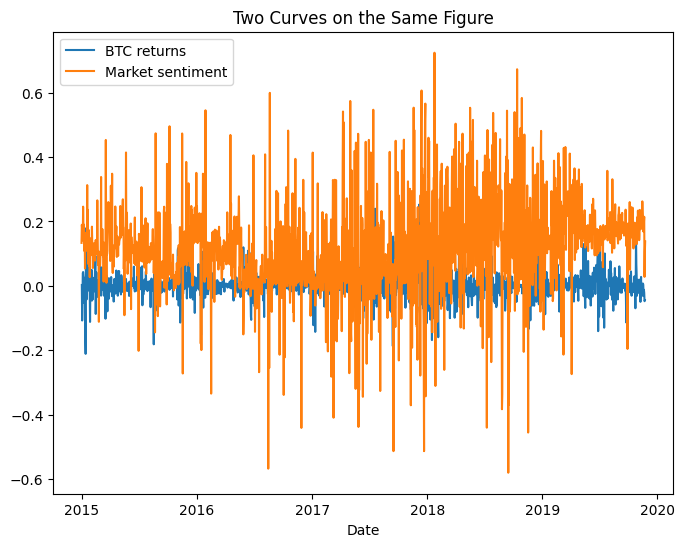

In [248]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(filtered_df_vader.index, btc_data['daily_return'].reindex(filtered_df_vader.index), label='BTC returns')  # Plot the first curve
plt.plot(filtered_df_vader.index, filtered_df_vader['weighted_avg_sentiment'].reindex(filtered_df_vader.index), label='Market sentiment')  # Plot the second curve

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('')
plt.title('Two Curves on the Same Figure')
plt.legend()

# Show the plot
plt.show()

4.2 Portfolio strategy 1 : Naïve approach

In [249]:
# Define the initial portfolio balance in USD
initial_balance = 100000
total_portfolio_value = 100000

# Initialize portfolio variables
portfolio_balance = initial_balance
btc_holdings = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_1 = []
btc_holdings_values_1 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in filtered_df_vader.iterrows():
    scaled_sentiment = row['scaled_sentiment']
    btc_price = btc_prices.loc[index]  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc = scaled_sentiment * total_portfolio_value - btc_holdings * btc_price

    # Update BTC holdings and portfolio balance
    btc_holdings += investment_in_btc / btc_price
    portfolio_balance -= investment_in_btc

    # Calculate the total portfolio value
    total_portfolio_value = portfolio_balance + (btc_holdings * btc_price)

    # Append values to the lists
    portfolio_values_1.append(total_portfolio_value)
    btc_holdings_values_1.append(btc_holdings)

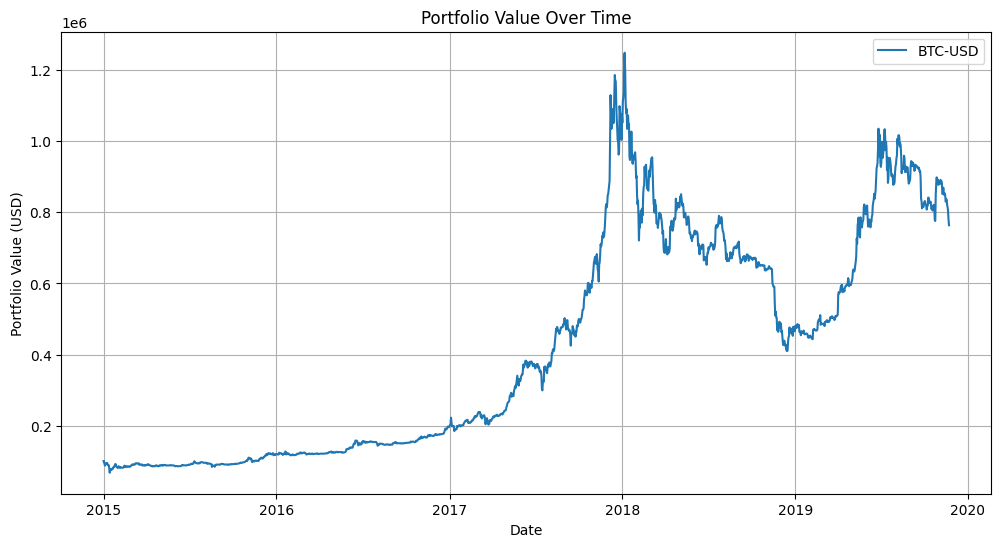

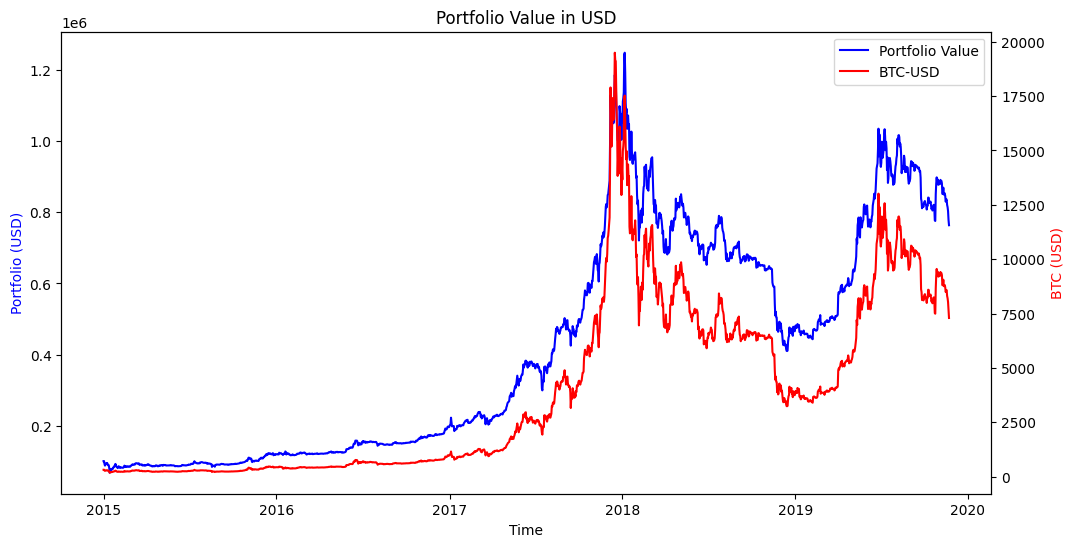

In [253]:
import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))

plt.plot(filtered_df_vader.index, portfolio_values_1, label='BTC-USD')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()


# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first curve on the first axis
ax1.plot(filtered_df_vader.index, portfolio_values_1, 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(filtered_df_vader.index, btc_prices, 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()


In [254]:
# Define the initial portfolio balance in USD
initial_balance_2 = 100000
total_portfolio_value_2 = 100000

# Initialize portfolio variables
portfolio_balance_2 = initial_balance_2
btc_holdings_2 = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_2 = []
btc_holdings_values_2 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in filtered_df_vader.iterrows():
    scaled_sentiment_2 = row['weighted_avg_sentiment']
    btc_price_2 = btc_prices.loc[index]  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc_2 = scaled_sentiment_2 * total_portfolio_value_2 - btc_holdings_2 * btc_price_2

    # Update BTC holdings and portfolio balance
    btc_holdings_2 += investment_in_btc_2 / btc_price_2
    portfolio_balance_2 -= investment_in_btc_2

    # Calculate the total portfolio value
    total_portfolio_value_2 = portfolio_balance_2 + (btc_holdings_2 * btc_price_2)

    # Append values to the lists
    portfolio_values_2.append(total_portfolio_value_2)
    btc_holdings_values_2.append(btc_holdings_2)

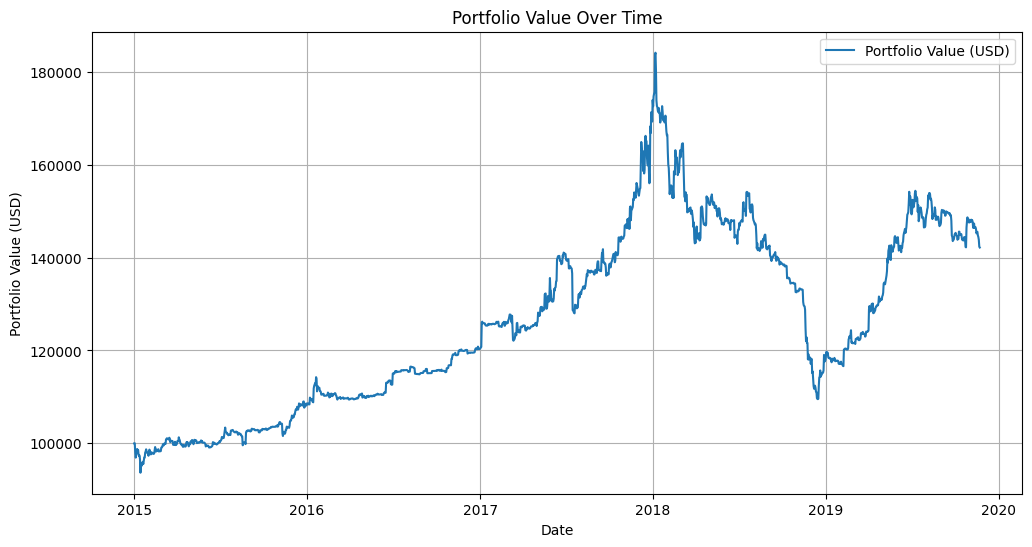

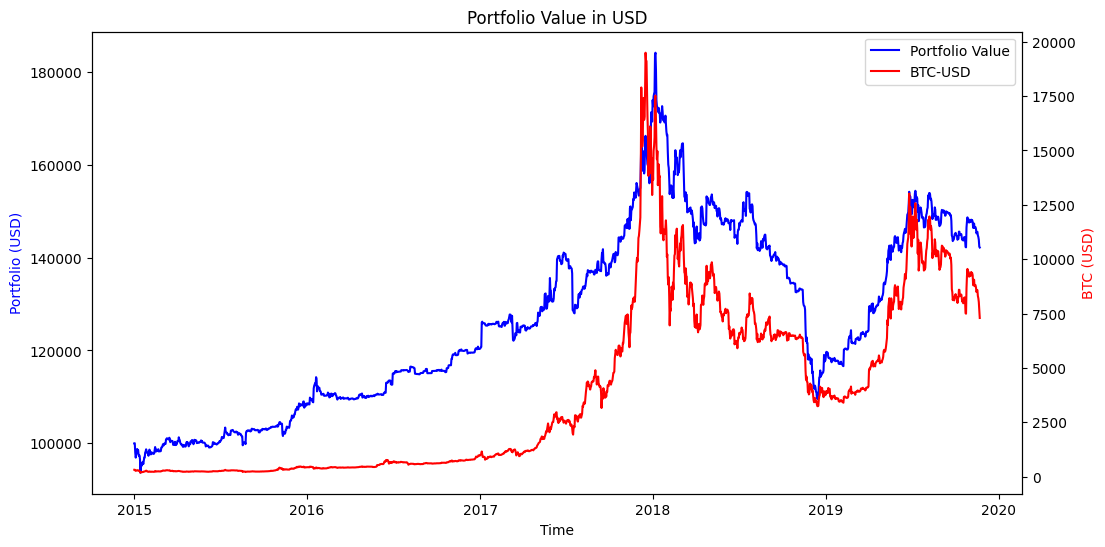

In [255]:
import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))
plt.plot(filtered_df_vader.index, portfolio_values_2, label='Portfolio Value (USD)')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first curve on the first axis
ax1.plot(filtered_df_vader.index, portfolio_values_2, 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(filtered_df_vader.index, btc_prices, 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_6714/3147387312.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(btc_prices[0])
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_6714/3147387312.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.plot(btc_prices.index, btc_prices/btc_prices[0], 'r', label='BTC-USD')


314.2489929199219


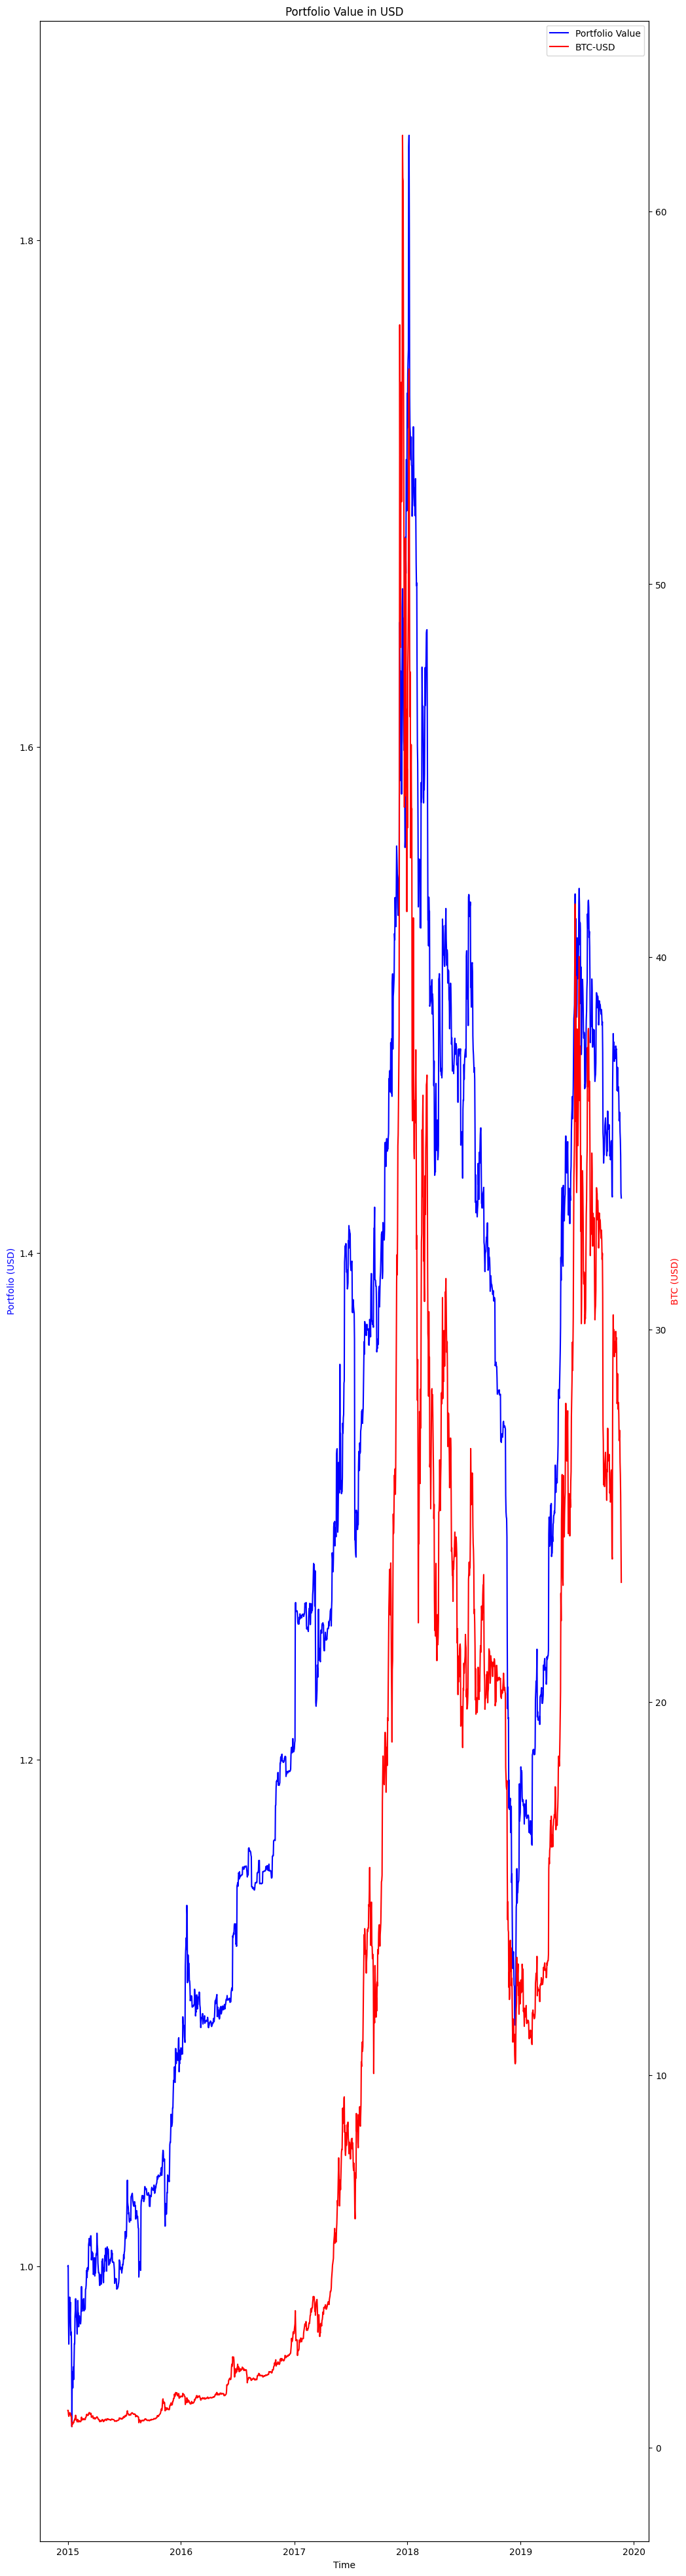

In [262]:
print(btc_prices[0])
# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 50))

# Plot the first curve on the first axis
ax1.plot(filtered_df_vader.index, portfolio_values_2/portfolio_values_2[0], 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(btc_prices.index, btc_prices/btc_prices[0], 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

In [236]:
# Define the initial portfolio balance in USD
initial_balance_3 = 100000
total_portfolio_value_3 = 100000

# Initialize portfolio variables
portfolio_balance_3 = initial_balance_3
btc_holdings_3 = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_3 = []
btc_holdings_values_3 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in filtered_df_vader.iterrows():
    scaled_sentiment_3 = row['scaled_sentiment']
    btc_price_3 = btc_prices.loc[index]  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc_3 = -scaled_sentiment_3 * total_portfolio_value_3 - btc_holdings_3 * btc_price_3

    # Update BTC holdings and portfolio balance
    btc_holdings_3 += investment_in_btc_3 / btc_price_3
    portfolio_balance_3 -= investment_in_btc_3

    # Calculate the total portfolio value
    total_portfolio_value_3 = portfolio_balance_3 + (btc_holdings_3 * btc_price_3)

    # Append values to the lists
    portfolio_values_3.append(total_portfolio_value_3)
    btc_holdings_values_3.append(btc_holdings_3)

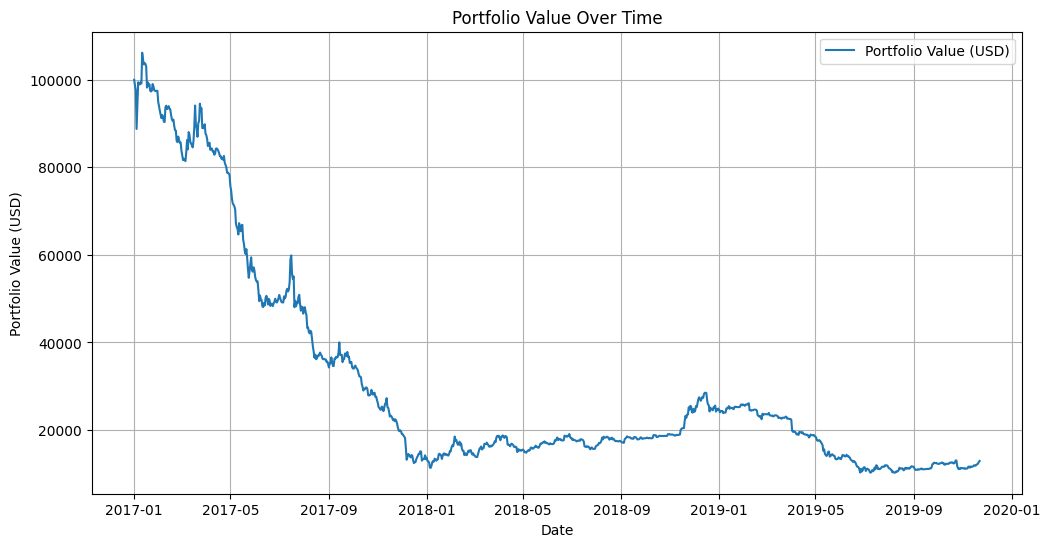

In [237]:
import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))
plt.plot(filtered_df_vader.index, portfolio_values_3, label='Portfolio Value (USD)')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

5. Comparison with FinBERT --- DOESNT WORK YET

In [22]:
# Initialize finBERT sentiment model
finbert_model_name = "ProsusAI/finbert"
max_length = 512  # You can adjust this value as needed
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_model_name, max_length=max_length)
finbert_model = BertForSequenceClassification.from_pretrained(finbert_model_name)

In [23]:
# Function to compute finBERT sentiment scores
def compute_finbert_sentiment(text):
    tokens = finbert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
    
    with torch.no_grad():
        output = finbert_model(**tokens)
        logit = output.logits
    return logit

In [55]:
import numpy as np
df['finbert_sentiment'] = np.zeros(len(df['text']))

#for i in range(1000):
    #df['finbert_sentiment'][i] = compute_finbert_sentiment(df['text'][i])
df['finbert_sentiment'][1] = compute_finbert_sentiment(df['text'][1])
#print(df['finbert_sentiment'][1])
#df['finbert_sentiment'][i] = df['text'][i].apply(compute_finbert_sentiment)
# Extract the sentiment score from finBERT results
# df['finbert_score'] = df['finbert_sentiment'].apply(lambda x: x[0][0].item())
df.head()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_6714/3092863782.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['finbert_sentiment'][1] = compute_finbert_sentiment(df['text'][1])


AttributeError: 'torch.dtype' object has no attribute 'kind'

In [ ]:
# Print the DataFrame with sentiment scores
print(df[['text', 'compound_score', 'finbert_score']])

In [58]:
import pandas as pd

ModuleNotFoundError: No module named 'finbert'

In [63]:
# Select the first 1000 tweets


OSError: yiyangiliu/finbert is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`